<a href="https://colab.research.google.com/github/fda-bert-ner/blob/master/phase-3/custom_ner_with_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import time
from itertools import chain
from os import path, mkdir

import matplotlib.pyplot as plt
import numpy as np
import spacy
from matplotlib.ticker import MaxNLocator
from spacy import displacy
from spacy.util import minibatch, compounding

In [2]:
if not path.isdir('data/'):
    mkdir('data/')
if not path.isdir('models/'):
    mkdir('models/')

Upload dataset files (`train.tsv`, `test.tsv`, `devel.tsv`, `train_dev.tsv`) in `data` folder

In [12]:
!curl https://github.com/hamza1886/fda-bert-ner/raw/master/phase-3/data/train.tsv -o data/train.tsv
!curl https://github.com/hamza1886/fda-bert-ner/raw/master/phase-3/data/test.tsv -o data/test.tsv
!curl https://github.com/hamza1886/fda-bert-ner/raw/master/phase-3/data/devel.tsv -o data/devel.tsv
!curl https://github.com/hamza1886/fda-bert-ner/raw/master/phase-3/data/train_dev.tsv -o data/train_dev.tsv

In [8]:
!python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
def load_data_spacy(file_path):
    """ Converts data from:
    label \t word \n label \t word \n \n label \t word
    to: sentence, {entities : [(start, end, label), (start, end, label)]}
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        file = f.readlines()

    training_data, entities, sentence, unique_labels = [], [], [], []
    start, end = 0, 0  # initialize counter to keep track of start and end characters

    for line in file:
        line = line.strip('\n').split('\t')
        # lines with len > 1 are words
        if len(line) > 1:
            label = line[1]
            label_type = label[0]  # beginning of annotations - "B-xxx", intermediate - "I-xxx"

            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)  # length of the word + trailing space

            if label_type == 'I':  # if at the end of an annotation
                entities.append((start, end - 1, label))  # append the annotation
            if label_type == 'B':  # if beginning new annotation
                entities.append((start, end - 1, label))  # start annotation at beginning of word

            if label != 'O' and label not in unique_labels:
                unique_labels.append(label)

        # lines with len == 1 are breaks between sentences
        if len(line) == 1:
            if len(entities) > 0:
                sentence = ' '.join(sentence)
                training_data.append([sentence, {'entities': entities}])
            # reset the counters and temporary lists
            start, end = 0, 0
            entities, sentence = [], []

    return training_data, unique_labels

In [5]:
def calc_precision(pred, true):
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20)  # true positives / total pred
    return precision


def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)  # true positives / total test
    return recall


def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

In [6]:
# run the predictions on each sentence in the test dataset, and return the spacy object
def evaluate(ner, data):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))]  # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents]  # i.label_ = annotation label, pred.ents = list of annotations

        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    return {
        'textcat_p': np.mean(precisions),
        'textcat_r': np.mean(recalls),
        'textcat_f': np.mean(f1s)
    }

In [7]:
def train_spacy(train_data, labels, iterations, dropout=0.2, display_freq=1):
    """ Train a spacy NER model, which can be queried against with test data

    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    """
    valid_f1scores, test_f1scores = [], []

    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
    # nlp = spacy.load('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe('ner')

    # Add entity labels to the NER pipeline
    for i in labels:
        ner.add_label(i)

    # Disable other pipelines in SpaCy to only train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        # nlp.vocab.vectors.name = 'spacy_model'  # without this, spaCy throws an "unnamed" error
        optimizer = nlp.begin_training()
        for itr in range(iterations):
            random.shuffle(train_data)  # shuffle the training data before each iteration
            losses = {}
            batches = minibatch(train_data, size=compounding(16., 64., 1.5))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,
                    annotations,
                    drop=dropout,
                    sgd=optimizer,
                    losses=losses)
            # if itr % display_freq == 0:
            #     print("Iteration {} Loss: {}".format(itr + 1, losses))

            print('\n========================================')
            print(f'Interaction = {str(itr + 1)}')
            print(f'Losses = {str(losses)}')

            scores = evaluate(nlp, VALID_DATA)
            valid_f1scores.append(scores["textcat_f"])
            print('========= VALID DATA ====================')
            print(f'Precision = {str(scores["textcat_p"])}')
            print(f'Recall = {str(scores["textcat_r"])}')
            print(f'F1-score = {str(scores["textcat_f"])}')

            scores = evaluate(nlp, TEST_DATA)
            test_f1scores.append(scores["textcat_f"])
            print('========= TEST DATA =====================')
            print(f'Precision = {str(scores["textcat_p"])}')
            print(f'Recall = {str(scores["textcat_r"])}')
            print(f'F1-score = {str(scores["textcat_f"])}')

    return nlp, valid_f1scores, test_f1scores

In [9]:
def load_model(model_path):
    """ Loads a pre-trained model for prediction on new test sentences

    model_path : directory of model saved by spacy.to_disk
    """
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)

    ner = nlp.from_disk(model_path)
    return ner

In [13]:
TRAIN_DATA, LABELS = load_data_spacy('data/train.tsv')  # 60% dataset
VALID_DATA, _ = load_data_spacy('data/devel.tsv')  # 20% dataset
TEST_DATA, _ = load_data_spacy('data/test.tsv')  # 20% dataset

In [ ]:
# Train (and save) the NER model
ner, valid_f1scores, test_f1scores = train_spacy(TRAIN_DATA, LABELS, 3)
ner.to_disk('models/spacy_example')


Interaction = 1
Losses = {'ner': 275079.580988884}
========= VALID DATA ====================
F1-score = 0.9390112830133799
Precision = 0.9299622025961068
Recall = 0.956476223056083
========= TEST DATA =====================
F1-score = 0.9288109282178669
Precision = 0.9222736246028971
Recall = 0.9448351707484678

Interaction = 2
Losses = {'ner': 246868.8635187149}
========= VALID DATA ====================
F1-score = 0.9753438646244779
Precision = 0.9728022044463435
Recall = 0.9810214391463193
========= TEST DATA =====================
F1-score = 0.9642398127485221
Precision = 0.9642974965456288
Recall = 0.9698022687997863


Text(0.5, 1.0, 'F1-score vs iterations for validation and test data')

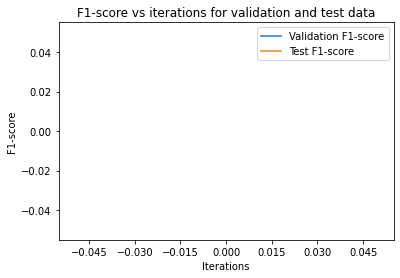

In [14]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(valid_f1scores, label='Validation F1-score')
ax.plot(test_f1scores, label='Test F1-score')
ax.set_xlabel('Iterations')
ax.set_ylabel('F1-score')
ax.legend()
ax.set_title('F1-score vs iterations for validation and test data')

In [15]:
# Let's test our model on test data
ner = load_model('models/spacy_example')

test_sentences = [x[0] for x in TEST_DATA[:100]]  # extract the sentences from [sentence, entity]
for test_sentence in test_sentences:
    doc = ner(test_sentence)
    # for ent in doc.ents:
        # print(ent.text, ent.start, ent.char, ent.end, ent.label)
    displacy.render(doc, jupyter=True, style='ent')